In [91]:
import numpy as np
import pandas as pd
from datetime import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Masking,Embedding

In [92]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=None, val_df=None, test_df=None,
               label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label slice: {self.labels_slice}',
            f'Input Slice: {self.input_slice}',
            f'Label column name(s): {self.label_columns}'])
    
    def plot(self, model=None, plot_col='Indoor_Mean', max_subplots=3):
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time [h]')

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
    # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
    # And cache it for next time
    self._example = result
    return result

In [93]:
df=pd.read_csv('../data/eplusout.csv')
df.head()

,Date/Time,Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep),Environment:Site Outdoor Air Drybulb Temperature [C](Hourly),Environment:Site Outdoor Air Dewpoint Temperature [C](TimeStep),Environment:Site Outdoor Air Dewpoint Temperature [C](Hourly),Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep),Environment:Site Outdoor Air Barometric Pressure [Pa](Hourly),Environment:Site Wind Speed [m/s](TimeStep),Environment:Site Wind Speed [m/s](Hourly),Environment:Site Wind Direction [deg](TimeStep),...,Carbon Equivalent:Facility [kg](Hourly),DistrictCooling:Facility [J](TimeStep),DistrictHeating:Facility [J](TimeStep),Carbon Equivalent:Facility [kg](TimeStep),BLOCK1:BEDROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](TimeStep),BLOCK1:BEDROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),BLOCK1:BATHROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](TimeStep),BLOCK1:BATHROOM:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly),BLOCK1:KITCHEN:Zone Mechanical Ventilation Air Changes per Hour [ach](TimeStep),BLOCK1:KITCHEN:Zone Mechanical Ventilation Air Changes per Hour [ach](Hourly)
0,04/01 00:10:00,15.433333,NaN,10.3,NaN,101250.666667,NaN,3.0,NaN,19.166667,...,NaN,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN
1,04/01 00:20:00,14.366667,NaN,10.0,NaN,101280.333333,NaN,2.9,NaN,8.333333,...,NaN,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN
2,04/01 00:30:00,13.300000,NaN,9.7,NaN,101310.000000,NaN,2.8,NaN,357.500000,...,NaN,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN
3,04/01 00:40:00,12.233333,NaN,9.4,NaN,101339.666667,NaN,2.7,NaN,346.666667,...,NaN,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN
4,04/01 00:50:00,11.166667,NaN,9.1,NaN,101369.333333,NaN,2.6,NaN,335.833333,...,NaN,0.0,50307.334955,0.0,0.0,NaN,0.0,NaN,0.0,NaN


In [94]:
datetimeform= []
for i in range(len(df.index)):
    tt = df["Date/Time"][i]
    days, hours = tt.split('  ')
    tt = f'{days.split("/")[1]}/{days.split("/")[0]}/2017{hours}'
    tt = tt.replace(' ', '')
    if '201724:' in tt:
        tt=tt.replace('24:', '00:')
        timestamp = time.mktime(datetime.strptime(tt, "%d/%m/%Y%H:%M:%S").timetuple())
        timestamp += 86400
        #timestamp = datetime.fromtimestamp(timestamp)
        
    else:
        timestamp = time.mktime(datetime.strptime(tt, "%d/%m/%Y%H:%M:%S").timetuple())
        #timestamp = datetime.fromtimestamp(timestamp)
    datetimeform.append(timestamp)
    
df["TimeStep"]=datetimeform
    

In [95]:
# Extract mean temp time series
# mean value of the 3 indoor zones
df2 = pd.DataFrame()
#"Date/Time",\
#"Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)",\
#"Electricity:Facility [J](TimeStep)"
df2 = df[[
          "BLOCK1:BEDROOM:Zone Mean Air Temperature [C](TimeStep:ON)",\
          "BLOCK1:BATHROOM:Zone Mean Air Temperature [C](TimeStep:ON)",\
          "BLOCK1:KITCHEN:Zone Mean Air Temperature [C](TimeStep:ON)",\
          ]]
df3=df2.copy()
df3.dropna(inplace=True)
df3["mean"] = df3.mean(1)


df_final=pd.DataFrame()
df_final["DateTime"] = df["TimeStep"]
df_final["Outdoor_Mean"] = df["Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)"]
df_final["Indoor_Mean"] = df3["mean"]
df_final["Cooling"] = df["DistrictCooling:Facility [J](TimeStep)"]
df_final["Power"]=df["Electricity:Facility [J](TimeStep)"]
df_final["Delta_T"] = df_final["Indoor_Mean"]-df_final["Outdoor_Mean"]
#df_final

In [96]:
x = pd.DataFrame()
meas = ["TimeStep","Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)",
        "Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep)",
        "Environment:Site Wind Speed [m/s](TimeStep)",
        "Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep)",
        "Environment:Site Wind Direction [deg](TimeStep)",
       "Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep)"]

x["Indoor_Mean"] = df3["mean"]
for m in meas:
    x[m]=df[m]
#x.set_index("TimeStep",inplace=True)
#x.head()

In [97]:
column_indices = {name: i for i, name in enumerate(x.columns)}
x.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Indoor_Mean,26352.0,2.573015e+01,4.657015e-01,2.276377e+01,2.553500e+01,2.600000e+01,2.600000e+01,2.666381e+01
TimeStep,26352.0,1.498904e+09,4.564387e+06,1.490998e+09,1.494951e+09,1.498904e+09,1.502856e+09,1.506809e+09
Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep),26352.0,2.478928e+01,5.281879e+00,9.200000e+00,2.165000e+01,2.520000e+01,2.883333e+01,3.800000e+01
Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep),26352.0,2.968390e+02,3.410445e+02,0.000000e+00,0.000000e+00,6.066667e+01,6.813333e+02,8.610000e+02
Environment:Site Wind Speed [m/s](TimeStep),26352.0,4.090316e+00,2.647121e+00,0.000000e+00,2.066667e+00,3.350000e+00,5.700000e+00,1.390000e+01
Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep),26352.0,1.011359e+05,2.632702e+02,9.989300e+04,1.010070e+05,1.012020e+05,1.012973e+05,1.020010e+05
Environment:Site Wind Direction [deg](TimeStep),26352.0,2.201309e+02,8.041293e+01,0.000000e+00,1.883333e+02,2.200000e+02,2.863750e+02,3.598333e+02
Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep),26352.0,7.695269e+01,8.235471e+01,0.000000e+00,0.000000e+00,5.100000e+01,1.456667e+02,4.480000e+02


In [98]:
num_features = x.shape[1]
print(num_features)

8


In [99]:
# Normalize features
x_train = x[:int(len(x)*0.7)]
x_train_norm = (x_train -x_train.mean())/x_train.std()
print("Training set dimension: ",len(x_train))

x_val =  x[int(len(x)*0.7):int(len(x)*0.9)]
x_val_norm = (x_val-x_train.mean())/x_train.std()
print("Validation set dimension: ",len(x_val))

x_test =  x[int(len(x)*0.9):]
x_test_norm = (x_test-x_train.mean())/x_train.std()
print("Test set dimension: ",len(x_test))

Training set dimension:  18446
Validation set dimension:  5270
Test set dimension:  2636


In [100]:
w1 = WindowGenerator(input_width=10, label_width=1, shift=1,
                     train_df=x_train_norm, val_df=x_val_norm, test_df=x_test_norm,
                     label_columns=['Indoor_Mean'])

In [101]:
w1

Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10]
Label slice: slice(10, None, None)
Input Slice: slice(0, 10, None)
Label column name(s): ['Indoor_Mean']

In [102]:
example_window = tf.stack([np.array(x_train_norm[0:w1.total_window_size]),
                  np.array(x_train_norm[100:100+w1.total_window_size]),
                  np.array(x_train_norm[200:200+w1.total_window_size]),
                 ])
example_inputs, example_labels = w1.split_window(example_window)
print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 11, 8)
Inputs shape: (3, 10, 8)
labels shape: (3, 1, 1)


In [103]:
#w1.example = example_inputs, example_labels
#w1.plot()

In [104]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [107]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
    # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
    # And cache it for next time
    self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [118]:
w1 = WindowGenerator(input_width=10, label_width=1, shift=1,
                     train_df=x_train_norm, val_df=x_val_norm, test_df=x_test_norm,
                     label_columns=['Indoor_Mean'])

In [119]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    return history

In [120]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32,stateful=True, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [121]:
history = compile_and_fit(lstm_model, w1)

IPython.display.clear_output()
val_performance = {}
val_performance['LSTM'] = lstm_model.evaluate(w1.val)
performance={}
performance['LSTM'] = lstm_model.evaluate(w1.test, verbose=0)

165/165 [==============================] - 3s 16ms/step - loss: 0.0216 - mean_absolute_error: 0.0800


In [129]:
def make_datasetDUMMY(data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
          data=data,
          targets=None,
          sequence_length=11,
          sequence_stride=1,
          shuffle=True,
          batch_size=32,)

    ds = ds.map(self.split_window)

    return ds
output = lstm_model.evaluate(make_datasetDUMMY(x_test_norm))

NameError: name 'self' is not defined

In [131]:
w1



Total window size: 11
Input indices: [0 1 2 3 4 5 6 7 8 9]
Label indices: [10]
Label slice: slice(10, None, None)
Input Slice: slice(0, 10, None)
Label column name(s): ['Indoor_Mean']

ValueError: x and y must be the same size

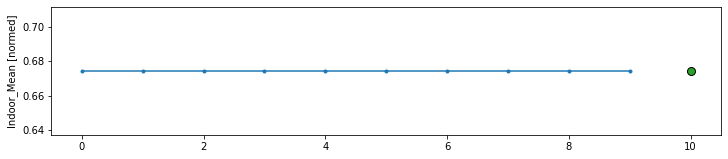

In [123]:
w1.plot(lstm_model,plot_col="Indoor_Mean")

Indoor_Mean                                                                5.223200e-01
TimeStep                                                                   3.195028e+06
Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)             5.493443e+00
Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep)     3.400756e+02
Environment:Site Wind Speed [m/s](TimeStep)                                2.662888e+00
Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep)            2.753979e+02
Environment:Site Wind Direction [deg](TimeStep)                            8.257197e+01
Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep)    8.721747e+01
dtype: float64


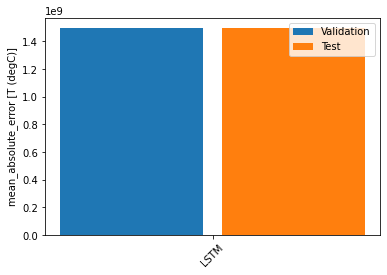

In [116]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

print(x_train.std())
val_mae = val_mae * x_train.std() + x_train.mean()
test_mae = test_mae * x_train.std() +x_train.mean()
plt.ylabel('mean_absolute_error [T (degC)]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [117]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

LSTM        : 0.3019
